In [100]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [101]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [102]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [103]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [104]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Sibal_1w46aws\AppData\Local\Temp\ipykernel_20364\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [105]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [106]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [107]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [108]:
# Find the most recent date in the data set.
start_date_str = session.query(func.max(Measurement.date)).scalar()
start_date_str

'2017-08-23'

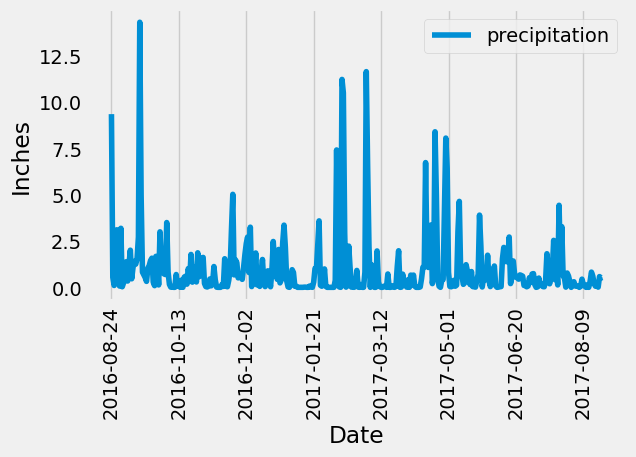

In [109]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
start_date = dt.datetime.strptime(start_date_str, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
end_date = start_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitations = session.query(
    Measurement.date,
    func.sum(Measurement.prcp).label('precipitation')
).filter(
    sqlalchemy.and_(
        Measurement.date <= start_date,
        Measurement.date >= end_date
    )
).group_by(Measurement.date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitations, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index('date')['precipitation'].plot()

plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

In [110]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_df = pd.DataFrame(precipitation_df["precipitation"].describe()).reset_index(names="")
summary_df

,,precipitation
0,count,365.000000
1,mean,0.974164
2,std,1.776466
3,min,0.000000
4,25%,0.050000
5,50%,0.400000
6,75%,1.080000
7,max,14.280000


# Exploratory Station Analysis

In [111]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).scalar()
total_stations

9

In [112]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Station.station,
    func.count(Station.station).label('count')
).join(Measurement, Station.station == Measurement.station)  # Join stations with measurements
active_stations = active_stations.group_by(Station.station).order_by(func.count(Station.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [113]:
active_stations[0][0]

'USC00519281'

In [114]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

session.query(
        func.min(Measurement.tobs).label('min_temp'),
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp')
    ).filter(Measurement.station == most_active_station).one()

(54.0, 85.0, 71.66378066378067)

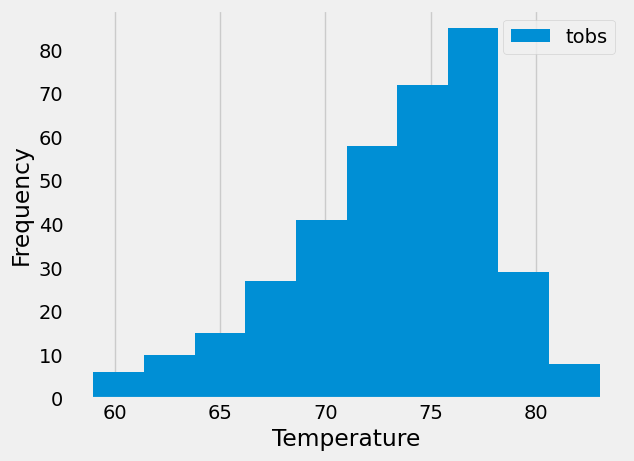

In [115]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_tobs = session.query(
        Measurement.date,
        Measurement.tobs
    ).filter(
        sqlalchemy.and_(
            Measurement.station == most_active_station,
            Measurement.date <= start_date,
            Measurement.date >= end_date
        )
    ).all()

most_active_station_df = pd.DataFrame(most_active_station_tobs, columns=['date', 'tobs'])

most_active_station_df['tobs'].plot(kind='hist')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')
plt.show()

# Close Session

In [116]:
# Close Session
session.close()